# Imports

In [2]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm, trange

import deepinv as dinv
from deepinv.optim.optimizers import optim_builder
from deepinv.physics.structured_random import generate_diagonal
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, plot_error_bars, spectral_methods_wrapper

/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import matplotlib.font_manager as fm

# Replace with the actual path from fc-list output
font_path = "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf"
fm.fontManager.addfont(font_path)

In [5]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 1 with 32491 MiB free memory 


device(type='cuda', index=1)

In [6]:
def clean_df(df_list, start=1.8,):
    for df in df_list:
        df.dropna(inplace=True)

        rows_to_drop = []
        left = start
        for index, row in df.iterrows():
            if row["oversampling_ratio"] - left < 0.2:
                rows_to_drop.append(index)
            else:
                left = row["oversampling_ratio"]
        df.drop(rows_to_drop, inplace=True) 

# Spectrum

The performance of the model depends on its spectrum distribution.

In [9]:
df_gaussian = pd.read_csv("../results/spectrum/full_marchenko/res_full-marchenko_shepp-logan_spec_0.10000000149011612-9.0_50repeat.csv")
df_unitary = pd.read_csv("../results/spectrum/full_unitary/res_full-unitary_shepp-logan_spec_1.0-9.0_50repeat.csv")
df_struct_unitary = pd.read_csv("../results/spectrum/struct_unitary/res_structured_unitary_FDFD_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_struct_marchenko = pd.read_csv("../results/spectrum/struct_marchenko/res_structured_uniform_marchenko_FDFD_shepp-logan_spec.csv")
df_marchenko_spectrum = pd.read_csv("../runs/20241125-114609/res_structured_marchenko_spectrum_FDFD_shepp-logan_spec.csv")

In [10]:
clean_df([df_struct_marchenko, df_struct_unitary,df_marchenko_spectrum],start=0.0)

In [11]:
df_gaussian.head()

,Unnamed: 0,oversampling_ratio,step_size,repeat0,repeat1,repeat2,repeat3,repeat4,repeat5,repeat6,...,repeat40,repeat41,repeat42,repeat43,repeat44,repeat45,repeat46,repeat47,repeat48,repeat49
0,0,0.1,NaN,0.000496,0.001532,0.003921,0.001789,0.007342,0.001358,0.003714,...,0.003396,0.006791,0.009774,0.002040,0.001275,0.002985,0.001903,0.003493,0.002549,0.005131
1,1,0.2,NaN,0.001532,0.006576,0.003342,0.002004,0.003758,0.005509,0.003624,...,0.002411,0.004026,0.005323,0.003403,0.002415,0.000915,0.004257,0.005187,0.001223,0.004091
2,2,0.3,NaN,0.002018,0.004660,0.005285,0.000373,0.002700,0.003106,0.002444,...,0.005738,0.006669,0.006990,0.003875,0.000469,0.003412,0.003048,0.002351,0.010067,0.001970
3,3,0.4,NaN,0.081640,0.011642,0.090625,0.084896,0.026331,0.063621,0.027831,...,0.038497,0.105877,0.073996,0.023588,0.015088,0.077047,0.031915,0.013527,0.076266,0.044405
4,4,0.5,NaN,0.091387,0.088070,0.098596,0.067611,0.032273,0.082904,0.101175,...,0.080385,0.030733,0.023237,0.061539,0.073116,0.029231,0.108597,0.054745,0.056667,0.089252


Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Unitary
(1.0, 0.4980392156862745, 0.054901960784313725) Unitary
Structured Marchenko
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Structured Marchenko
Structured Unitary
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) Structured Unitary
Different way to define spectrum
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) Different way to define spectrum


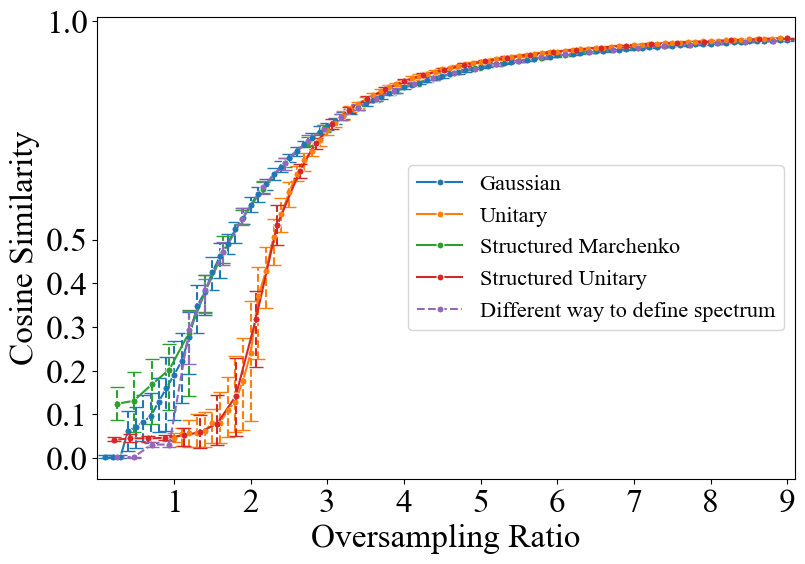

In [12]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_unitary["oversampling_ratio"],
        df_struct_marchenko["oversampling_ratio"],
        df_struct_unitary["oversampling_ratio"],
        df_marchenko_spectrum["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_unitary,
        df_struct_marchenko,
        df_struct_unitary,
        df_marchenko_spectrum,
    ],
    [
        "Gaussian",
        "Unitary",
        "Structured Marchenko",
        "Structured Unitary",
        "Different way to define spectrum",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[1,2,3,4,5,6,7,8,9],
    yticks=[0.0,0.1,0.2,0.3,0.4,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

# Diagonal Distribution

In [60]:
df_marchenko_uniform = pd.read_csv("../results/spectrum/struct_marchenko/res_structured_uniform_marchenko_FDFD_shepp-logan_spec.csv")
df_marchenko_laplace = pd.read_csv("../results/diagonal_distribution/laplace/res_structured_laplace_marchenko_FDFD_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_marchenko_quadrant = pd.read_csv("../results/diagonal_distribution/quadrant/res_structured_quadrant_marchenko_FDFD_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")

In [61]:
clean_df([df_marchenko_uniform, df_marchenko_laplace, df_marchenko_quadrant],start=0.0)

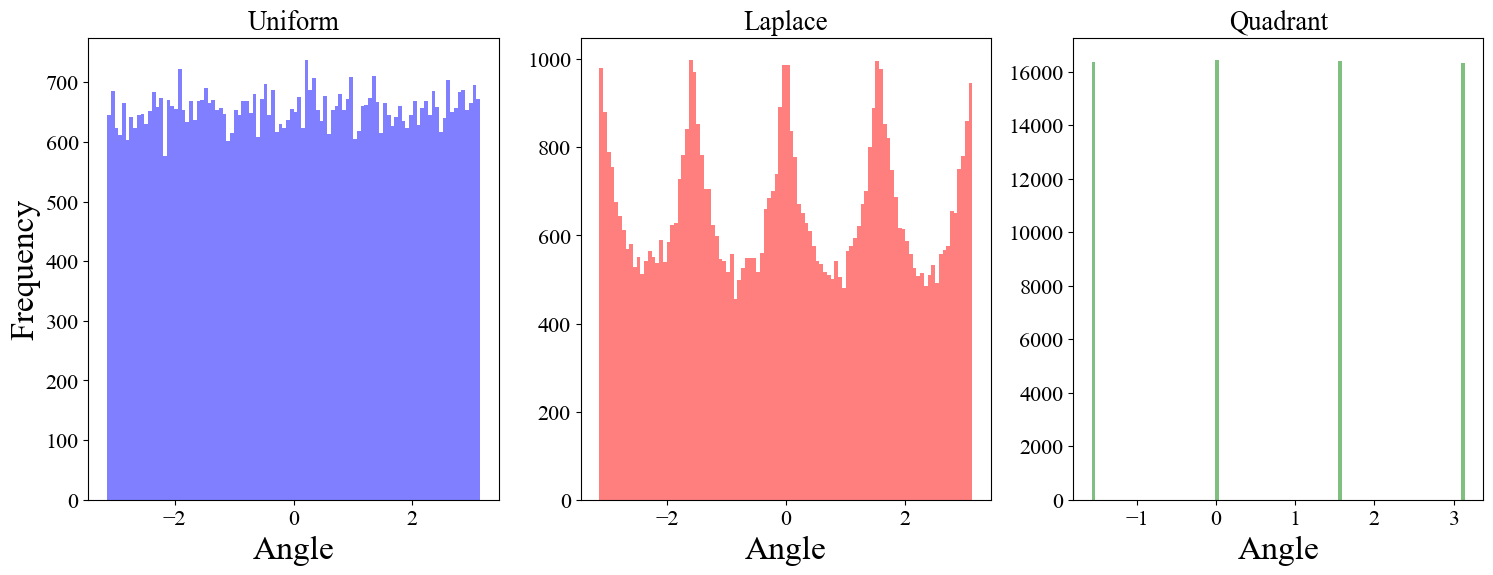

In [62]:
diagonal_uniform = generate_diagonal((256,256),['unit','uniform'])
diagonal_laplace = generate_diagonal((256,256),['unit','laplace'])
diagonal_quadrant = generate_diagonal((256,256),['unit','quadrant'])

fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(diagonal_uniform.angle().flatten(), bins=100, color='blue', alpha=0.5, label='Uniform')
ax[0].set_title('Uniform')
ax[0].set_xlabel('Angle')
ax[0].set_ylabel('Frequency')
ax[1].hist(diagonal_laplace.angle().flatten(), bins=100, color='red', alpha=0.5, label='Laplace')
ax[1].set_title('Laplace')
ax[1].set_xlabel('Angle')
ax[2].hist(diagonal_quadrant.angle().flatten(), bins=100, color='green', alpha=0.5, label='Quadrant')
ax[2].set_title('Quadrant')
ax[2].set_xlabel('Angle')
plt.show()

Uniform
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Uniform
Laplace
(1.0, 0.4980392156862745, 0.054901960784313725) Laplace
Quadrant
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Quadrant


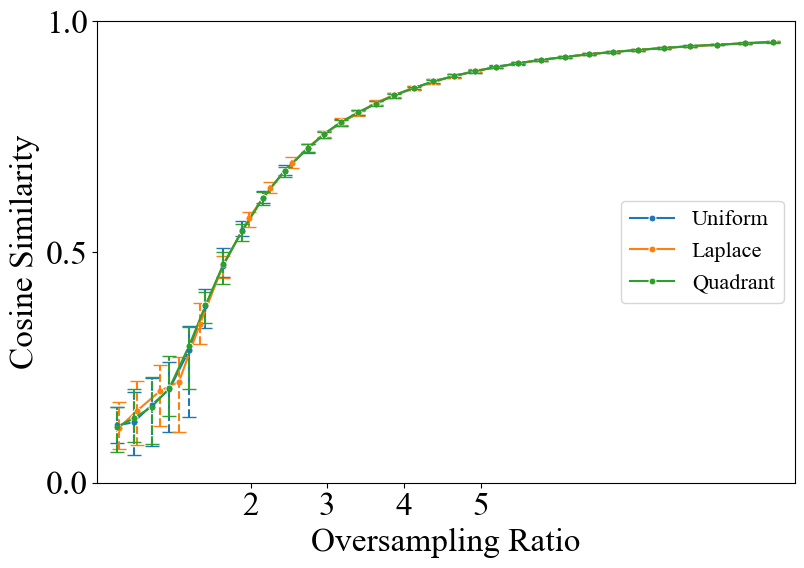

In [63]:
plot_error_bars(
    [
        df_marchenko_uniform["oversampling_ratio"],
        df_marchenko_laplace["oversampling_ratio"],
        df_marchenko_quadrant["oversampling_ratio"],
    ],
    [
        df_marchenko_uniform,
        df_marchenko_laplace,
        df_marchenko_quadrant,
    ],
    [
        "Uniform",
        "Laplace",
        "Quadrant",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

# Transform

In [6]:
df_fft = pd.read_csv("../results/spectrum/struct_marchenko/res_structured_uniform_marchenko_FDFD_shepp-logan_spec.csv")
df_dct = pd.read_csv("../results/transform/dct/res_structured_dct_FDFD_shepp-logan_spec.csv")
df_hadamard_1 = pd.read_csv("../results/transform/hadamard1/res_structured_hadamard_FDFD_shepp-logan_spec_1.0-1.4853999614715576_20repeat.csv")
df_hadamard_2 = pd.read_csv("../results/transform/hadamard2/res_structured_hadamard_FDFD_shepp-logan_spec_2.9540998935699463-3.399399995803833_20repeat.csv")
df_hadamard_3 = pd.read_csv("../runs/20241118-160008/res_structured_hadamard_FDFD_shepp-logan_spec.csv")
df_fft_padded = pd.read_csv("../runs/20241120-172911/res_structured_fft_padded_FDFD_shepp-logan_spec.csv")
df_dct_padded = pd.read_csv("../runs/20241120-173128/res_structured_dct_padded_FDFD_shepp-logan_spec.csv")
df_fft_padded_marchenko = pd.read_csv("../runs/20241126-093403/res_structured_marchenko_fft_padded_FDFD_shepp-logan_spec.csv")
df_dct_padded_marchenko = pd.read_csv("../runs/20241126-093451/res_structured_marchenko_dct_padded_FDFD_shepp-logan_spec.csv")
df_hadamard_marchenko = pd.read_csv("../runs/20241127-175510/res_structured_hadamard_FDFD_shepp-logan_spec.csv")
df_hadamard_marchenko_2 = pd.read_csv("../runs/20241128-133532/res_structured_hadamard_FDFD_shepp-logan_spec.csv")

df_gaussian = pd.read_csv("../results/spectrum/full_marchenko/res_full-marchenko_shepp-logan_spec_0.10000000149011612-9.0_50repeat.csv")
df_unitary = pd.read_csv("../results/spectrum/full_unitary/res_full-unitary_shepp-logan_spec_1.0-9.0_50repeat.csv")

In [7]:
clean_df([df_fft, df_dct,df_fft_padded,df_dct_padded, df_fft_padded_marchenko,df_dct_padded_marchenko, df_hadamard_marchenko, df_hadamard_marchenko_2],start=0.0)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Unitary
(1.0, 0.4980392156862745, 0.054901960784313725) Unitary
FFT
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) FFT
DCT
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) DCT
FFT Padded
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) FFT Padded
DCT Padded
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) DCT Padded
FFT Padded Marchenko
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902) FFT Padded Marchenko
DCT Padded Marchenko
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745) DCT Padded Marchenko
Hadamard Marchenko
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333) Hadamard Marchenko


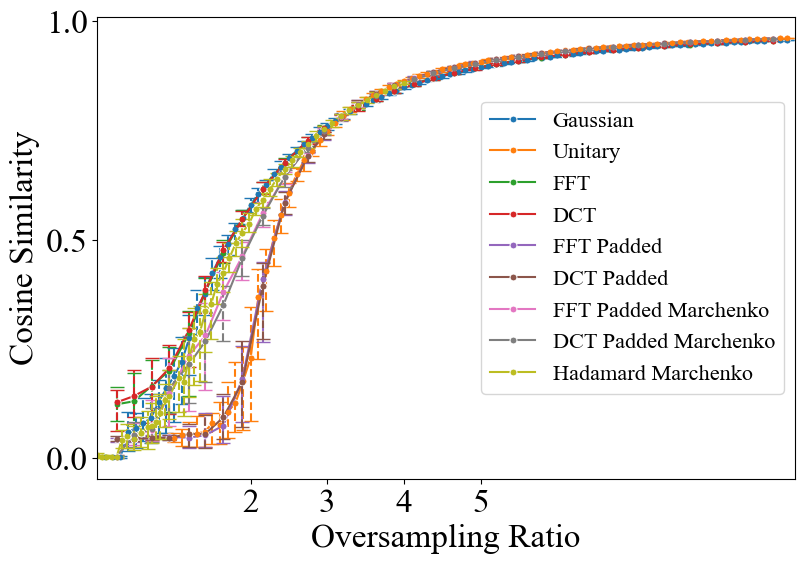

In [ ]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_unitary["oversampling_ratio"],
        df_fft["oversampling_ratio"],
        df_dct["oversampling_ratio"],
        # df_hadamard_1["oversampling_ratio"],
        # df_hadamard_2["oversampling_ratio"],
        # df_hadamard_3["oversampling_ratio"],
        df_fft_padded["oversampling_ratio"],
        df_dct_padded["oversampling_ratio"],
        df_fft_padded_marchenko["oversampling_ratio"],
        df_dct_padded_marchenko["oversampling_ratio"],
        df_hadamard_marchenko["oversampling_ratio"],
        df_hadamard_marchenko_2["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_unitary,
        df_fft,
        df_dct,
        # df_hadamard_1,
        # df_hadamard_2,
        # df_hadamard_3,
        df_fft_padded,
        df_dct_padded,
        df_fft_padded_marchenko,
        df_dct_padded_marchenko,
        df_hadamard_marchenko,
        df_hadamard_marchenko_2,
    ],
    [
        "Gaussian",
        "Unitary",
        "FFT",
        "DCT",
        # "Hadamard 1",
        # "Hadamard 2",
        # "Hadamard 3",
        "FFT Padded",
        "DCT Padded",
        "FFT Padded Marchenko",
        "DCT Padded Marchenko",
        "Hadamard Marchenko",
        "Hadamard Marchenko 2",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

In [11]:
df_fft_padded_128 = pd.read_csv("../runs/20241128-180811/res_structured_fft_padded128_FDFD_unit_shepp-logan_spec.csv")
df_dct_padded_128 = pd.read_csv("../runs/20241128-180708/res_structured_dct_padded128_FDFD_unit_shepp-logan_spec.csv")
df_hadamard_128 = pd.read_csv("../runs/20241128-180915/res_structured_hadamard_padded128_FDFD_unit_shepp-logan_spec.csv")

df_fft_padded_unitary_128 = pd.read_csv("../runs/20241129-205355/res_structured_unitary_fft_padded128_FDFD_unit_shepp-logan_spec.csv")
df_dct_padded_unitary_128 = pd.read_csv("../runs/20241129-205416/res_structured_unitary_dct_padded128_FDFD_unit_shepp-logan_spec.csv")
df_hadamard_unitary_128 = pd.read_csv("../runs/20241129-205321/res_structured_unitary_hadamard_padded128_FDFD_unit_shepp-logan_spec.csv")

df_gaussian = pd.read_csv("../results/spectrum/full_marchenko/res_full-marchenko_shepp-logan_spec_0.10000000149011612-9.0_50repeat.csv")
df_unitary = pd.read_csv("../results/spectrum/full_unitary/res_full-unitary_shepp-logan_spec_1.0-9.0_50repeat.csv")

In [12]:
clean_df([df_fft_padded_128, df_dct_padded_128, df_hadamard_128, df_fft_padded_unitary_128, df_dct_padded_unitary_128, df_hadamard_unitary_128],start=0.0)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Unitary
(1.0, 0.4980392156862745, 0.054901960784313725) Unitary
FFT Padded 128
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) FFT Padded 128
DCT Padded 128
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) DCT Padded 128
Hadamard 128
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) Hadamard 128
FFT Padded Unitary 128
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) FFT Padded Unitary 128
DCT Padded Unitary 128
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902) DCT Padded Unitary 128
Hadamard Unitary 128
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745) Hadamard Unitary 128


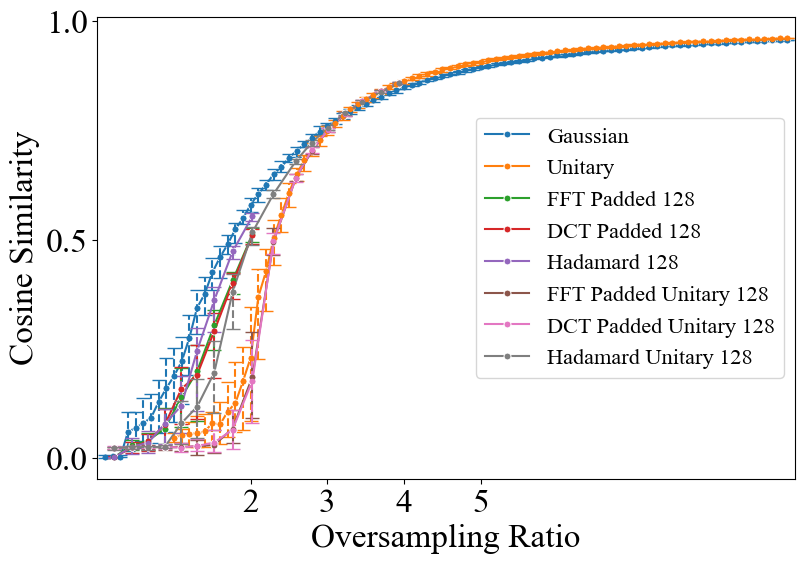

In [13]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_unitary["oversampling_ratio"],
        df_fft_padded_128["oversampling_ratio"],
        df_dct_padded_128["oversampling_ratio"],
        df_hadamard_128["oversampling_ratio"],
        df_fft_padded_unitary_128["oversampling_ratio"],
        df_dct_padded_unitary_128["oversampling_ratio"],
        df_hadamard_unitary_128["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_unitary,
        df_fft_padded_128,
        df_dct_padded_128,
        df_hadamard_128,
        df_fft_padded_unitary_128,
        df_dct_padded_unitary_128,
        df_hadamard_unitary_128,
    ],
    [
        "Gaussian",
        "Unitary",
        "FFT Padded 128",
        "DCT Padded 128",
        "Hadamard 128",
        "FFT Padded Unitary 128",
        "DCT Padded Unitary 128",
        "Hadamard Unitary 128",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

## Marchenko right diagonal

In [7]:
df_fft = pd.read_csv("../runs/20241202-132456/res_structured_fft_padded128_FDFD_unit_shepp-logan_spec.csv")
df_dct = pd.read_csv("../runs/20241202-132428/res_structured_dct_padded128_FDFD_unit_shepp-logan_spec.csv")
df_hadamard = pd.read_csv("../runs/20241202-132553/res_structured_hadamard_marchenko_padded128_FDFD_unit_shepp-logan_spec.csv")

df_gaussian = pd.read_csv("../results/spectrum/full_marchenko/res_full-marchenko_shepp-logan_spec_0.10000000149011612-9.0_50repeat.csv")

In [8]:
clean_df([df_fft, df_dct, df_hadamard],start=0.0)

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
FFT Marchenko Padded 128
(1.0, 0.4980392156862745, 0.054901960784313725) FFT Marchenko Padded 128
DCT Marchenko Padded 128
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) DCT Marchenko Padded 128
Hadamard Marchenko 128
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) Hadamard Marchenko 128


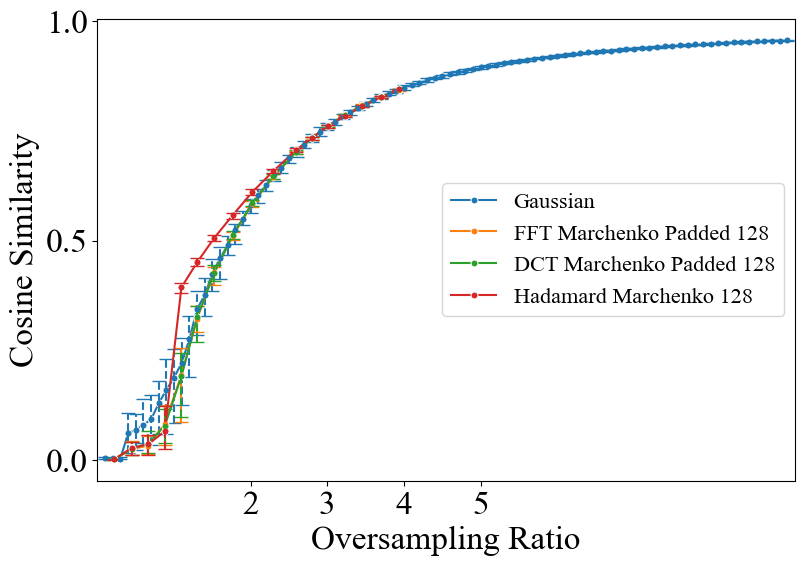

In [9]:
plot_error_bars(
    [
        df_gaussian["oversampling_ratio"],
        df_fft["oversampling_ratio"],
        df_dct["oversampling_ratio"],
        df_hadamard["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_fft,
        df_dct,
        df_hadamard,
    ],
    [
        "Gaussian",
        "FFT Marchenko Padded 128",
        "DCT Marchenko Padded 128",
        "Hadamard Marchenko 128",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

# Sparsity of the Signal

In [8]:
# try different images
df_shepplogan_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241014-123605/res_structured_FDF_shepp-logan_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_random_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241014-123951/res_structured_FDF_random_spec_0.0010000000474974513-9.0_50repeat.csv")
df_delta_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241014-124113/res_structured_FDF_delta_spec_0.0010000000474974513-9.0_50repeat.csv")
df_reverse_shepplogan_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-140719/res_structured_shepplogan_reverse_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary3_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241014-124214/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary5_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-114418/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary10_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-114509/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary20_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-114527/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary40_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-114541/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")

In [9]:
df_full_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/data/accuracy/res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")
df_marchenko_FD_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241016-112516/res_structured_marchenko-pastur-FD_shepp-logan_spec_1.0635000467300415-9.0_50repeat.csv")
df_uniform_mag_FD_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241016-125620/res_structured_uniform_magnitude_FD_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")

In [ ]:
clean_df([df_shepplogan_fdf, df_random_fdf, df_delta_fdf, df_shepplogan_vary3_fdf, df_shepplogan_vary5_fdf, df_shepplogan_vary10_fdf, df_shepplogan_vary20_fdf, df_shepplogan_vary40_fdf, df_reverse_shepplogan_fdf, df_full_spec, df_marchenko_FD_spec, df_uniform_mag_FD_spec], start=0.0)

Shepp-Logan
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Shepp-Logan
Random
(1.0, 0.4980392156862745, 0.054901960784313725) Random
Delta
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Delta
Shepp-Logan varying max 3
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) Shepp-Logan varying max 3
Shepp-Logan varying max 5
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) Shepp-Logan varying max 5
Shepp-Logan varying max 10
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) Shepp-Logan varying max 10
Shepp-Logan varying max 20
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902) Shepp-Logan varying max 20
Shepp-Logan varying max 40
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745) Shepp-Logan varying max 40
Reverse Shepp-Logan
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333) Reverse Shepp-Logan


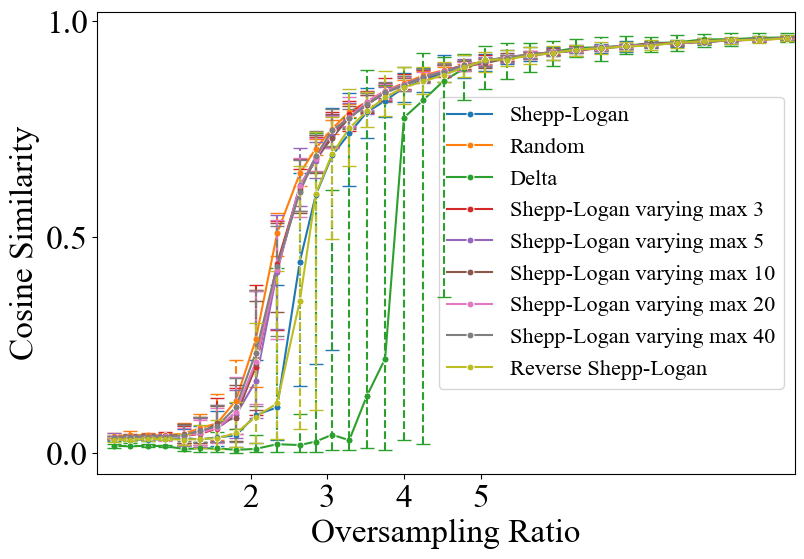

In [13]:
# different images
plot_error_bars(
    [
        df_shepplogan_fdf["oversampling_ratio"],
        df_random_fdf["oversampling_ratio"],
        df_delta_fdf["oversampling_ratio"],
        df_shepplogan_vary3_fdf["oversampling_ratio"],
        df_shepplogan_vary5_fdf["oversampling_ratio"],
        df_shepplogan_vary10_fdf["oversampling_ratio"],
        df_shepplogan_vary20_fdf["oversampling_ratio"],
        df_shepplogan_vary40_fdf["oversampling_ratio"],
        df_reverse_shepplogan_fdf["oversampling_ratio"],
    ],
    [
        df_shepplogan_fdf,
        df_random_fdf,
        df_delta_fdf,
        df_shepplogan_vary3_fdf,
        df_shepplogan_vary5_fdf,
        df_shepplogan_vary10_fdf,
        df_shepplogan_vary20_fdf,
        df_shepplogan_vary40_fdf,
        df_reverse_shepplogan_fdf
    ],
    [
        "Shepp-Logan",
        "Random",
        "Delta",
        "Shepp-Logan varying max 3",
        "Shepp-Logan varying max 5",
        "Shepp-Logan varying max 10",
        "Shepp-Logan varying max 20",
        "Shepp-Logan varying max 40",
        "Reverse Shepp-Logan",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

# Normalized Gaussian

In [44]:
df_normalized_gaussian = pd.read_csv("../results/full_matrix/normalized_gaussian/res_full-unit_shepp-logan_spec_0.10000000149011612-5.0_50repeat.csv")
df_gaussian = pd.read_csv("../results/accuracy/res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")

Gaussian
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Gaussian
Normalized Gaussian
(1.0, 0.4980392156862745, 0.054901960784313725) Normalized Gaussian


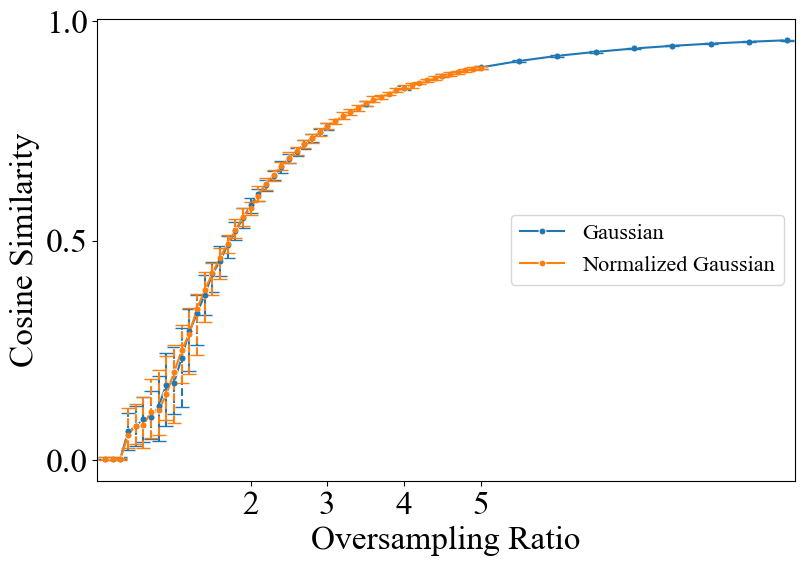

In [45]:
# plot
plot_error_bars([
        df_gaussian["oversampling_ratio"],
        df_normalized_gaussian["oversampling_ratio"],
    ],
    [
        df_gaussian,
        df_normalized_gaussian,
    ],
    [
        "Gaussian",
        "Normalized Gaussian",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

# Marchenko

In [14]:
#df_uniform_marchenko = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241029-185514/res_structured_marchenko_uniform_phase_FDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_uniform_marchenko = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241106-172205/res_structured_uniform_marchenko_FDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_gaussian = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/data/accuracy/res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")
df_marchenko_uniform = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241104-151154/res_structured_marchenko_uniform_FDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_marchenko_uniform = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241101-193810/res_structured_marchenko_uniform_FDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_marchenko_uniform_uniform = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241101-192548/res_structured_marchenko_3layer_FDFDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_marchenko_square = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241104-151118/res_structured_marchenko_square_FDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_marchenko_cubic = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241104-150936/res_structured_marchenko_cubic_FDFDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_marchenko_5 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241106-121957/res_structured_marchenko5_FDFDFDFDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_marchenko_6 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241106-122400/res_structured_marchenko6_FDFDFDFDFDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_semicircle_02 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241105-163254/res_structured_semicircle0.2_uniform_FDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_semicircle_04 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241105-163413/res_structured_semicircle0.4_uniform_FDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_semicircle_06 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241105-163528/res_structured_semicircle0.6_uniform_FDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_semicircle_08 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241105-163555/res_structured_semicircle0.8_uniform_FDFD_shepp-logan_spec_1.1963000297546387-9.0_50repeat.csv")
df_uniform_phase = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/data/accuracy/res_pseudorandom_2_spectral_100repeat_5000iter_0.0009765625-9.0.csv")

df_gaussian_1 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241111-131904/res_full-product1_shepp-logan_spec_0.10000000149011612-5.0_50repeat.csv")
df_gaussian_2 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241111-131428/res_full-product2_shepp-logan_spec_0.10000000149011612-5.0_50repeat.csv")
df_gaussian_3 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241111-131552/res_full-product3_shepp-logan_spec_0.10000000149011612-5.0_50repeat.csv")
df_gaussian_4 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241111-160443/res_full-product4_shepp-logan_spec_0.10000000149011612-5.0_50repeat.csv")

df_hadamard = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/runs/20241111-181108/res_structured_hadamard_FDFD_shepp-logan_spec_2.9540998935699463-3.399399995803833_20repeat.csv")

In [15]:
clean_df([df_uniform_marchenko, df_gaussian, df_marchenko_uniform, df_marchenko_uniform_uniform, df_marchenko_square, df_marchenko_cubic, df_marchenko_5, df_marchenko_6, df_uniform_phase,df_semicircle_02,df_semicircle_04,df_semicircle_06,df_semicircle_08,df_gaussian_1,df_gaussian_2,df_gaussian_3,df_gaussian_4,df_hadamard], start=0.0)

unit + Marcheko
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) unit + Marcheko
Marchenko + unit
(1.0, 0.4980392156862745, 0.054901960784313725) Marchenko + unit
Marchenko * 2
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Marchenko * 2
Marchenko * 3
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) Marchenko * 3
Gaussian * 1
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) Gaussian * 1
Gaussian * 2
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) Gaussian * 2
Gaussian * 3
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902) Gaussian * 3
Gaussian * 4
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745) Gaussian * 4
Hadamard
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333) Hadamard


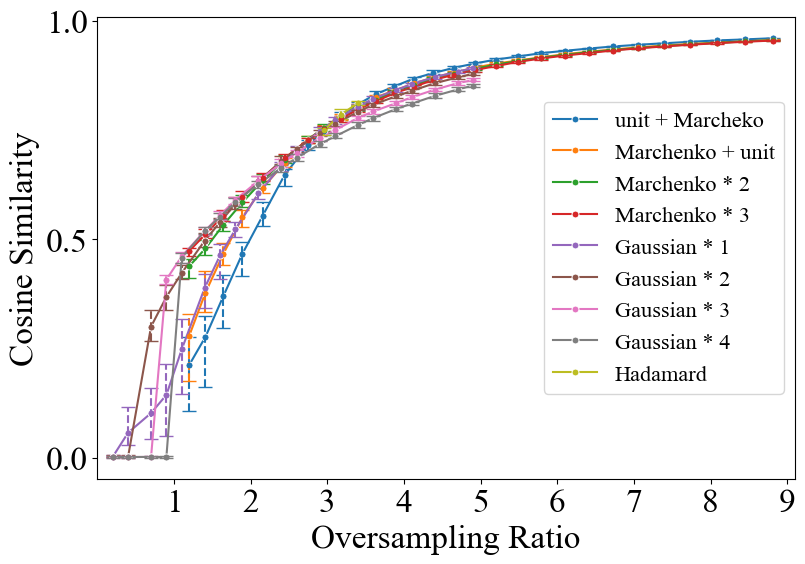

In [16]:
# plot
plot_error_bars(
    oversamplings=[
        #df_gaussian["oversampling_ratio"],
        df_uniform_marchenko["oversampling_ratio"],
        df_marchenko_uniform["oversampling_ratio"],
        # df_marchenko_uniform_uniform["oversampling_ratio"],
        df_marchenko_square["oversampling_ratio"],
        df_marchenko_cubic["oversampling_ratio"],
        # df_marchenko_5["oversampling_ratio"],
        # df_marchenko_6["oversampling_ratio"],
        df_gaussian_1["oversampling_ratio"],
        df_gaussian_2["oversampling_ratio"],
        df_gaussian_3["oversampling_ratio"],
        df_gaussian_4["oversampling_ratio"],

        df_hadamard["oversampling_ratio"],
        # df_uniform_phase["oversampling_ratio"],
        # df_semicircle_02["oversampling_ratio"],
        # df_semicircle_04["oversampling_ratio"],
        # df_semicircle_06["oversampling_ratio"],
        # df_semicircle_08["oversampling_ratio"],
    ],
    datasets=[
        #df_gaussian,
        df_uniform_marchenko,
        df_marchenko_uniform,
        # df_marchenko_uniform_uniform,
        df_marchenko_square,
        df_marchenko_cubic,
        # df_marchenko_5,
        # df_marchenko_6,
        df_gaussian_1,
        df_gaussian_2,
        df_gaussian_3,
        df_gaussian_4,

        df_hadamard,
        # df_uniform_phase,
        # df_semicircle_02,
        # df_semicircle_04,
        # df_semicircle_06,
        # df_semicircle_08,
    ],
    labels=[
        #"i.i.d. Gaussian",
        "unit + Marcheko",
        "Marchenko + unit",
        # "Marchenko + unit + unit",
        "Marchenko * 2",
        "Marchenko * 3",
        # "Marchenko * 5",
        # "Marchenko * 6",
        "Gaussian * 1",
        "Gaussian * 2",
        "Gaussian * 3",
        "Gaussian * 4",

        "Hadamard",
        # "uniform phase",
        # "semicircle 0.2",
        # "semicircle 0.4",
        # "semicircle 0.6",
        # "semicircle 0.8",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[1,2,3,4,5,6,7,8,9],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

unit + Marcheko
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) unit + Marcheko
Marchenko + unit
(1.0, 0.4980392156862745, 0.054901960784313725) Marchenko + unit
Marchenko * 2
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Marchenko * 2
Marchenko * 3
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) Marchenko * 3
Gaussian * 1
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) Gaussian * 1
Gaussian * 2
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) Gaussian * 2
Gaussian * 3
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902) Gaussian * 3
Gaussian * 4
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745) Gaussian * 4


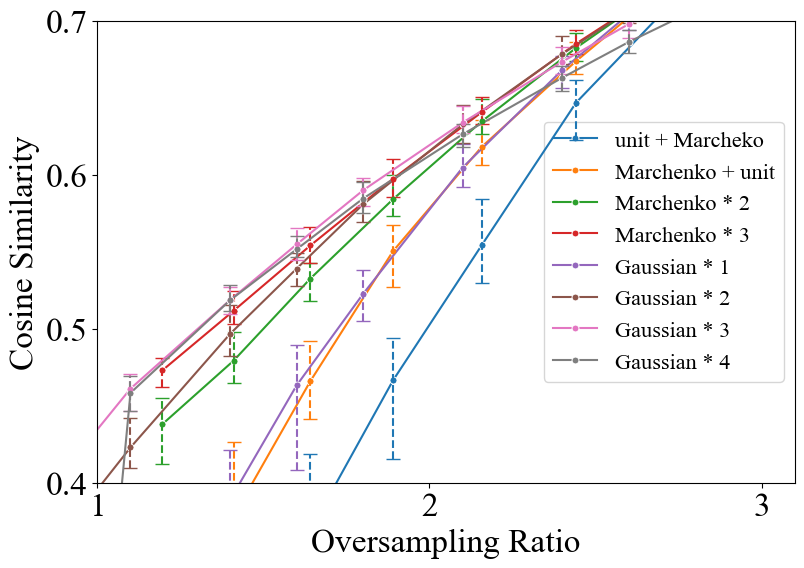

In [13]:
# plot
plot_error_bars(
    oversamplings=[
        #df_gaussian["oversampling_ratio"],
        df_uniform_marchenko["oversampling_ratio"],
        df_marchenko_uniform["oversampling_ratio"],
        # df_marchenko_uniform_uniform["oversampling_ratio"],
        df_marchenko_square["oversampling_ratio"],
        df_marchenko_cubic["oversampling_ratio"],
        # df_marchenko_5["oversampling_ratio"],
        # df_marchenko_6["oversampling_ratio"],
        df_gaussian_1["oversampling_ratio"],
        df_gaussian_2["oversampling_ratio"],
        df_gaussian_3["oversampling_ratio"],
        df_gaussian_4["oversampling_ratio"],
        # df_uniform_phase["oversampling_ratio"],
        # df_semicircle_02["oversampling_ratio"],
        # df_semicircle_04["oversampling_ratio"],
        # df_semicircle_06["oversampling_ratio"],
        # df_semicircle_08["oversampling_ratio"],
    ],
    datasets=[
        #df_gaussian,
        df_uniform_marchenko,
        df_marchenko_uniform,
        # df_marchenko_uniform_uniform,
        df_marchenko_square,
        df_marchenko_cubic,
        # df_marchenko_5,
        # df_marchenko_6,
        df_gaussian_1,
        df_gaussian_2,
        df_gaussian_3,
        df_gaussian_4,
        # df_uniform_phase,
        # df_semicircle_02,
        # df_semicircle_04,
        # df_semicircle_06,
        # df_semicircle_08,
    ],
    labels=[
        #"i.i.d. Gaussian",
        "unit + Marcheko",
        "Marchenko + unit",
        # "Marchenko + unit + unit",
        "Marchenko * 2",
        "Marchenko * 3",
        # "Marchenko * 5",
        # "Marchenko * 6",
        "Gaussian * 1",
        "Gaussian * 2",
        "Gaussian * 3",
        "Gaussian * 4",
        # "uniform phase",
        # "semicircle 0.2",
        # "semicircle 0.4",
        # "semicircle 0.6",
        # "semicircle 0.8",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(1.0,3.1),
    xticks=[1,2,3],
    ylim=(0.4,0.7),
    yticks=[0.4,0.5,0.6,0.7],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

# Reconstruction Visualization 

torch.Size([1, 1, 128, 128])


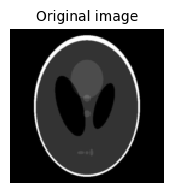

In [8]:
# generate signal
img_size = 128
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
print(x.shape)
plot(x, titles="Original image",fontsize=10)

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [9]:
# create 3 models with different oversampling: 2.0, 2.5, 3.0

output_sizes = {1:180, 2:202, 3:221}
recons = [x]

for i in range(1,4):
    physics = dinv.physics.StructuredRandomPhaseRetrieval(
        n_layers=2,
        input_shape=(1, img_size, img_size),
        output_shape=(1, output_sizes[i], output_sizes[i]),
        drop_tail=True,
        shared_weights=True,
        dtype = torch.cfloat,
        device=device,
    )

    y = physics.forward(x_phase)

    params_algo = {"stepsize": 6e-3*physics.oversampling_ratio.item(), "g_params": 0.00}

    model = optim_builder(
        iteration="PGD",
        prior=dinv.optim.prior.Zero(),
        data_fidelity=dinv.optim.data_fidelity.L2(),
        early_stop=True,
        max_iter=20000,
        verbose=False,
        params_algo=params_algo,
        custom_init=spectral_methods_wrapper,
    )

    x_phase_recon = model(y, physics, x_gt=x_phase)
    x_phase_recon = correct_global_phase(x_phase_recon,x_phase)
    x_recon = torch.angle(x_phase_recon) / (2*torch.pi) + 0.5
    recons.append(x_recon)

Image 0, channel 0 does not have a global phase shift.
Power iteration early stopping at iteration 4680.
Image 0, channel 0 does not have a global phase shift.
Power iteration early stopping at iteration 1911.
Image 0, channel 0 does not have a global phase shift.


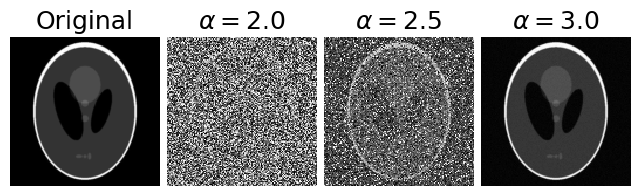

In [16]:
# visuliazation
plot(recons, figsize=(8,3), titles=["Original",r"$\alpha=2.0$", r"$\alpha=2.5$", r"$\alpha=3.0$"],save='paper/figures/recons.pdf',fontsize=18,transparent=True,)

# Reconstruction Accuracy

In [14]:
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/paper/data/accuracy")

In [15]:
df_random_gd_spec = pd.read_csv(load_path/"res_random_gd_spectral_100repeat_10000iter_0.10000000149011612-9.0.csv")
df_random_gd_spec_small = pd.read_csv(load_path /"res_random_gd_spectral_100repeat_10000iter_2.0-2.5999999046325684.csv")
df_random_spec = pd.read_csv(load_path /"res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")
df_random_gd_rand = pd.read_csv(load_path /"res_random_gd_random_100repeat_10000iter_0.10000000149011612-9.0.csv")
df_structured_gd_spec = pd.read_csv(load_path /"res_structured_gd_spectral_100repeat_10000iter_0.0001020304043777287-9.0.csv")
df_structured_spec = pd.read_csv(load_path /"res_structured_2_spectral_100repeat_5000iter_0.0009765625-9.0.csv")
df_structured_gd_rand = pd.read_csv(load_path /"res_structured_2_gd-rand_100repeat_10000iter_0.0009765625-9.0.csv")

In [ ]:
df_structured_spec.head(n=15)
df_structured_gd_spec.dtypes

In [17]:
for oversampling_ratio in [2.0,2.1,2.2,2.3,2.4,2.5,2.6]:
    df_random_gd_spec.loc[df_random_gd_spec["oversampling_ratio"] == oversampling_ratio] = df_random_gd_spec_small.loc[df_random_gd_spec_small["oversampling_ratio"] == oversampling_ratio].values

In [19]:
for df in [df_random_gd_spec, df_random_spec, df_random_gd_rand]:
    rows_to_drop = []
    for index, row in df.iterrows():
        if round(row['oversampling_ratio']*10) % 2 != 0 and row['oversampling_ratio']< 3.0:
            rows_to_drop.append(index)

    df.drop(rows_to_drop, inplace=True)

In [20]:
for df in [df_structured_gd_rand, df_structured_gd_spec, df_structured_spec]:
    rows_to_drop = []
    left = -0.15
    for index, row in df.iterrows():
        if row["oversampling_ratio"] - left < 0.2:
            rows_to_drop.append(index)
        else:
            left = row["oversampling_ratio"]
    df.drop(rows_to_drop, inplace=True) 

In [21]:
oversampling_ratios_random_gd_spec = df_random_gd_spec["oversampling_ratio"]
oversampling_ratios_random_spec = df_random_spec["oversampling_ratio"]
oversampling_ratios_random_gd_rand = df_random_gd_rand["oversampling_ratio"]
oversampling_ratios_structured_gd_spec = df_structured_gd_spec["oversampling_ratio"]
oversampling_ratios_structured_spec = df_structured_spec["oversampling_ratio"]
oversampling_ratios_structured_gd_rand = df_structured_gd_rand["oversampling_ratio"]

iid gd spec
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid gd spec
iid spec
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid spec
iid gd rand
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid gd rand
structured gd spec
(1.0, 0.4980392156862745, 0.0) structured gd spec
structured spec
(1.0, 0.4980392156862745, 0.0) structured spec
structured gd rand
(1.0, 0.4980392156862745, 0.0) structured gd rand
Figure saved to paper/figures/accuracy.pdf


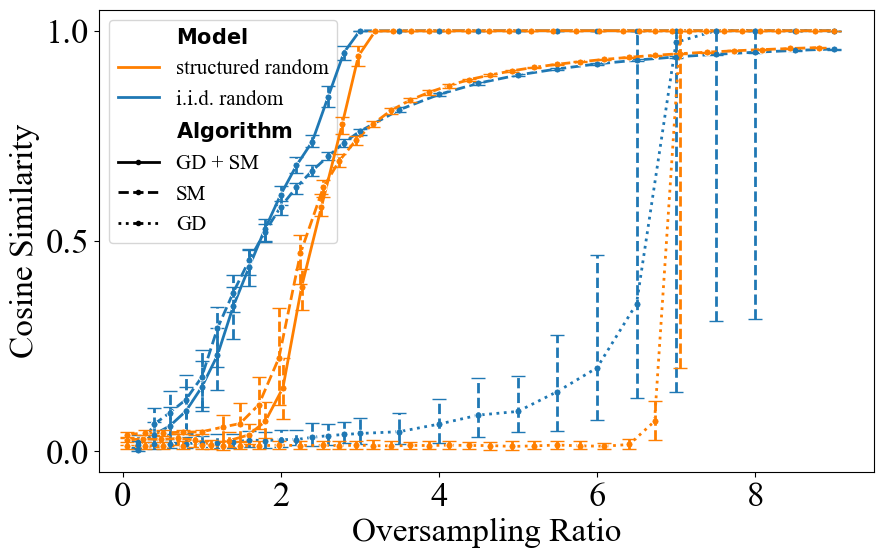

In [22]:
plot_error_bars([oversampling_ratios_random_gd_spec,
                 oversampling_ratios_random_spec,oversampling_ratios_random_gd_rand,oversampling_ratios_structured_gd_spec,oversampling_ratios_structured_spec,
                 oversampling_ratios_structured_gd_rand],
                [df_random_gd_spec,
                 df_random_spec,
                 df_random_gd_rand,
                 df_structured_gd_spec,
                 df_structured_spec,
                 df_structured_gd_rand],
                ['iid gd spec',
                 'iid spec',
                 'iid gd rand',
                 'structured gd spec',
                 'structured spec',
                 'structured gd rand'],
                figsize=(10,6),
                font="Times New Roman",
                fontsize=15,
                labelsize=24,
                xlim=(-0.3,9.5),
                yticks=[0.0,0.5,1.0],
                error_bar_linestyle="--",
                structured_color=sns.color_palette("Paired")[7],
                iid_color=sns.color_palette("Paired")[1],
                plot='reconstruction',
                ticksize=25,
                show=False,
                save_dir='paper/figures/accuracy.pdf')

# Time Complexity

In [23]:
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/paper/data/time")

In [24]:
df_random_cpu = pd.read_csv(load_path / "df_random_cpu.csv")
df_random_gpu = pd.read_csv(load_path / "df_random_gpu.csv")
df_structured_cpu = pd.read_csv(load_path / "df_structured_cpu.csv")
df_structured_gpu = pd.read_csv(load_path / "df_structured_gpu.csv")

In [25]:
df_random_gpu.iloc[0]["img_size_8"] = None
df_random_gpu

/tmp/ipykernel_3498706/1141376657.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_random_gpu.iloc[0]["img_size_8"] = None


,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,NaN,0.000501,0.000638,0.000540,0.001046,0.003431,0.007872,0.016202,0.029026,0.031205
1,0.000252,0.000467,0.000466,0.000386,0.001200,0.003330,0.007773,0.016022,0.023464,0.031089
2,0.000179,0.000460,0.000462,0.000367,0.001196,0.003243,0.007803,0.016826,0.023490,0.031042
3,0.000170,0.000459,0.000453,0.000364,0.001208,0.003246,0.007780,0.016126,0.023477,0.031130
4,0.000168,0.000459,0.000451,0.000364,0.001168,0.003349,0.007809,0.015985,0.023582,0.031191
...,...,...,...,...,...,...,...,...,...,...
95,0.000164,0.000173,0.000174,0.000299,0.001241,0.003373,0.007748,0.016134,0.023584,0.031102
96,0.000164,0.000172,0.000170,0.000296,0.001233,0.003400,0.007826,0.016018,0.023588,0.030983
97,0.000164,0.000172,0.000168,0.000296,0.001230,0.003401,0.007770,0.016045,0.023482,0.031095
98,0.000165,0.000174,0.000168,0.000297,0.001246,0.003392,0.007826,0.015952,0.023474,0.031016


In [26]:
img_sizes_iid: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
img_sizes_structured: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
num_pixels_iid = [img_sizes_iid**2 for img_sizes_iid in img_sizes_iid]
num_pixels_structured = [img_sizes_structured**2 for img_sizes_structured in img_sizes_structured]

i.i.d. random (CPU)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) i.i.d. random (CPU)
i.i.d. random (GPU)
(1.0, 0.4980392156862745, 0.054901960784313725) i.i.d. random (GPU)
structured random (CPU)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) structured random (CPU)
structured random (GPU)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) structured random (GPU)
Figure saved to paper/figures/time.pdf


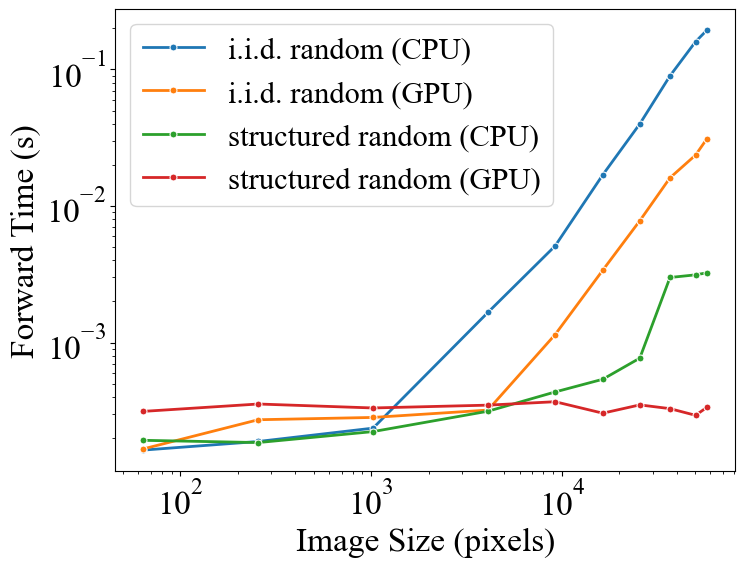

In [27]:
plot_error_bars([num_pixels_iid,
                 num_pixels_iid,
                 num_pixels_structured,
                 num_pixels_structured],
                [df_random_cpu,
                 df_random_gpu,
                 df_structured_cpu,
                 df_structured_gpu],
                ['i.i.d. random (CPU)','i.i.d. random (GPU)','structured random (CPU)','structured random (GPU)'],
                axis=0,
                figsize=(8,6),
                xscale='log',
                yscale='log',
                xlabel='Image Size (pixels)',
                ylabel='Forward Time (s)',
                legend_loc='upper left',
                plot='time',
                error_bar='std',
                save_dir='paper/figures/time.pdf',
                fontsize=22,
                labelsize=24,
                ticksize=24,
                bbox_inches = 'tight')